# Exploratory Data Analysis

In [21]:
#import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
from datetime import datetime, date, timedelta
from pandas import DataFrame
import requests
import json
import random

In [22]:
#Download data set for explore a case count
url = "https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv"
data = pd.read_csv(url,
				 encoding= 'utf8', 
				 usecols=['Bundesland', 'AnzahlFall', 'Meldedatum'],
				 parse_dates=['Meldedatum'])

bundesland_cases = data.groupby(['Bundesland', 'Meldedatum'], as_index = False)['AnzahlFall'].sum()
bundesland_cases = bundesland_cases.set_index("Meldedatum").sort_index()
print(bundesland_cases)    

                        Bundesland  AnzahlFall
Meldedatum                                    
2020-01-02     Nordrhein-Westfalen           1
2020-01-03       Baden-Württemberg           1
2020-01-12     Nordrhein-Westfalen           1
2020-01-18             Brandenburg           1
2020-01-28                  Bayern           2
2020-01-28     Nordrhein-Westfalen           1
2020-01-29                  Bayern           2
2020-01-30     Nordrhein-Westfalen           1
2020-01-31                  Bayern           5
2020-01-31                Saarland           1
2020-02-03                  Bayern           1
2020-02-04           Niedersachsen           1
2020-02-04                  Bayern           3
2020-02-06                  Bayern           1
2020-02-07                  Bayern           1
2020-02-11                  Bayern           2
2020-02-12     Nordrhein-Westfalen           1
2020-02-12                  Bayern           1
2020-02-20     Nordrhein-Westfalen           1
2020-02-24   

                Bundesland  AnzahlFall
0        Baden-Württemberg      170872
1                   Bayern      238390
2                   Berlin       73393
3              Brandenburg       23365
4                   Bremen       10967
5                  Hamburg       27359
6                   Hessen       99519
7   Mecklenburg-Vorpommern        7056
8            Niedersachsen       79170
9      Nordrhein-Westfalen      294646
10         Rheinland-Pfalz       51180
11                Saarland       14412
12                 Sachsen       73733
13          Sachsen-Anhalt       15822
14      Schleswig-Holstein       16274
15               Thüringen       22016


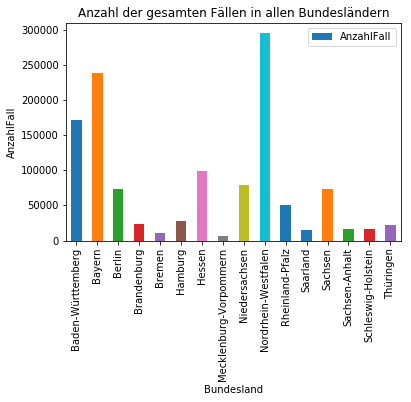

In [20]:
# accumulate cases per Bundesland

bundesland_cases_sum = data.groupby(['Bundesland'], as_index = False)['AnzahlFall'].sum()
print(bundesland_cases_sum)
bundesland_cases_sum.plot(x ='Bundesland', y='AnzahlFall', kind = 'bar')

plt.title('Anzahl der gesamten Fällen in allen Bundesländern')
plt.xlabel('Bundesland')
plt.ylabel('AnzahlFall')
plt.show()

Folgende Schritte werden analysiert:
- Wir haben festgestellt, dass die meisten Cases in folgenden Bundesländer vorkommen:
  Baden-Württemberg, Bayern, Berlin, Hessen, Neidersachsen, NRW, Rheinland-Pfalz und Sachsen. Diese würden wir   ein bisschen genauer anschauen, um festzustellen, welche Maßnahmen dort eingeführt waren
- Und umgekehrt wollen wir die Bunderländer betrachten, die nicht so viele Anzahl der Fällen enthalten, welche Maßnahmen sind dort eingeführt
- Vergleichen die beiden Ergebnisse -> Abhängigkeiten herausfinden?

